# 03 - Results & Analysis (WT3)

This notebook consolidates the **final results** of all trained models for the wind turbine power prediction task (turbine **WT3**).

In [1]:
import json
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib


## A — Training on one turbine (Results & Analysis)

### 1 — Loading saved experiment results

Each model run stores a JSON report in `../reports/` with validation and test metrics.
We load all available results for turbine WT3 and build a comparison table.


In [2]:
REPORTS_DIR = Path("../reports")
pattern = str(REPORTS_DIR / "results_*_WT3.json")

rows = []
for path in glob.glob(pattern):
    with open(path, "r", encoding="utf-8") as f:
        rows.append(json.load(f))

df_res = pd.DataFrame(rows)

# Keep only the columns we care about (safe if some metrics missing)
cols = [c for c in ["model","turbine","mae_val","mae_test","rmse_val","rmse_test","r2_val","r2_test","mape_val","mape_test"] if c in df_res.columns]
df_res = df_res[cols].sort_values("mae_test")

df_res


,model,turbine,mae_val,mae_test,rmse_val,rmse_test,r2_val,r2_test,mape_val,mape_test
1,hgb,WT3,16.004460,22.556199,45.118007,46.760876,0.985666,0.992294,138.856148,138.741077
2,mlp,WT3,19.715223,25.609274,45.655045,54.985393,0.985323,0.989345,134.300284,84.539803
0,extratrees,WT3,27.088180,31.697818,61.896774,65.736483,0.973022,0.984771,125.380964,119.406181
3,ridge,WT3,105.212237,104.151882,136.619398,136.085792,0.868571,0.934733,9130.001370,5989.249140


### 2 — Models comparaison (main metrics)

We prioritize:
- **MAE**: easy to interpret in power units (kW)
- **RMSE**: penalizes large errors
- **R²**: explained variance


In [3]:
# Create a clean comparison view
view_cols = [c for c in ["model","mae_test","rmse_test","r2_test","mae_val","rmse_val","r2_val","mape_test"] if c in df_res.columns]
df_view = df_res[view_cols].copy()

# Round for readability
for c in df_view.columns:
    if c != "model":
        df_view[c] = df_view[c].astype(float).round(3)

df_view


,model,mae_test,rmse_test,r2_test,mae_val,rmse_val,r2_val,mape_test
1,hgb,22.556,46.761,0.992,16.004,45.118,0.986,138.741
2,mlp,25.609,54.985,0.989,19.715,45.655,0.985,84.540
0,extratrees,31.698,65.736,0.985,27.088,61.897,0.973,119.406
3,ridge,104.152,136.086,0.935,105.212,136.619,0.869,5989.249


### 3 — Visual comparison (MAE on test set)

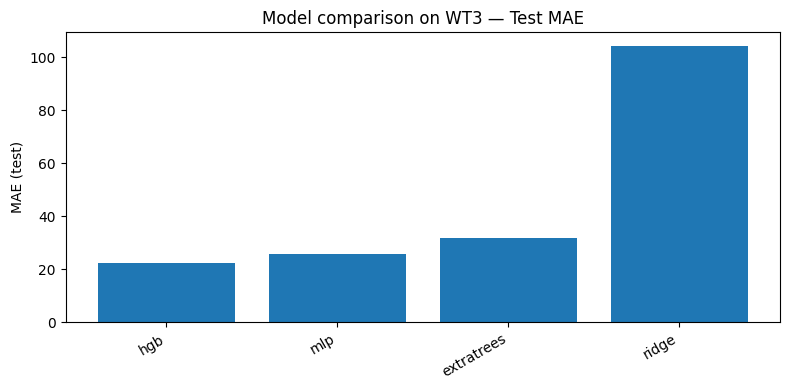

In [4]:
plt.figure(figsize=(8,4))
plt.bar(df_res["model"], df_res["mae_test"])
plt.ylabel("MAE (test)")
plt.title("Model comparison on WT3 — Test MAE")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


### 4 — Loading the best model


In [5]:
MODELS_DIR = Path("../models")

# Prefer val MAE for selection (if available); otherwise use test MAE
score_col = "mae_val" if "mae_val" in df_res.columns else "mae_test"
best_row = df_res.sort_values(score_col).iloc[0]

best_model_name = best_row["model"]
best_turbine = best_row["turbine"]
model_path = MODELS_DIR / f"{best_model_name}_{best_turbine}.joblib"

best_model_name, str(model_path)


('hgb', '..\\models\\hgb_WT3.joblib')

In [7]:
import sys
from pathlib import Path

ROOT = Path("..").resolve()
sys.path.append(str(ROOT))

In [8]:
from src.data import load_dataset, time_split

PARQUET_PATH = "../data/engie_full.parquet"

df = load_dataset(PARQUET_PATH, turbine="WT3")
X_train, y_train, X_val, y_val, X_test, y_test = time_split(df)

best_pipe = joblib.load(model_path)
y_pred = best_pipe.predict(X_test)

print("Best model:", best_model_name)


Best model: hgb


### 5 — Prediction vs True values (test set)

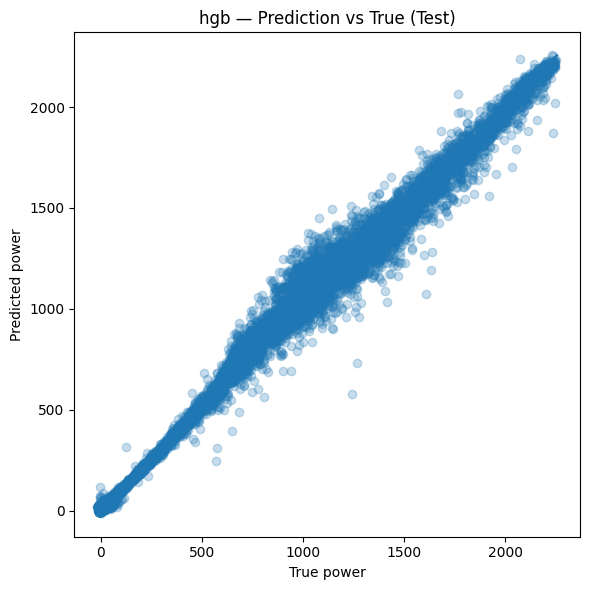

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.25)
mn = float(min(y_test.min(), y_pred.min()))
mx = float(max(y_test.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True power")
plt.ylabel("Predicted power")
plt.title(f"{best_model_name} — Prediction vs True (Test)")
plt.tight_layout()
plt.show()

### 6 — Predictions over time (sample)

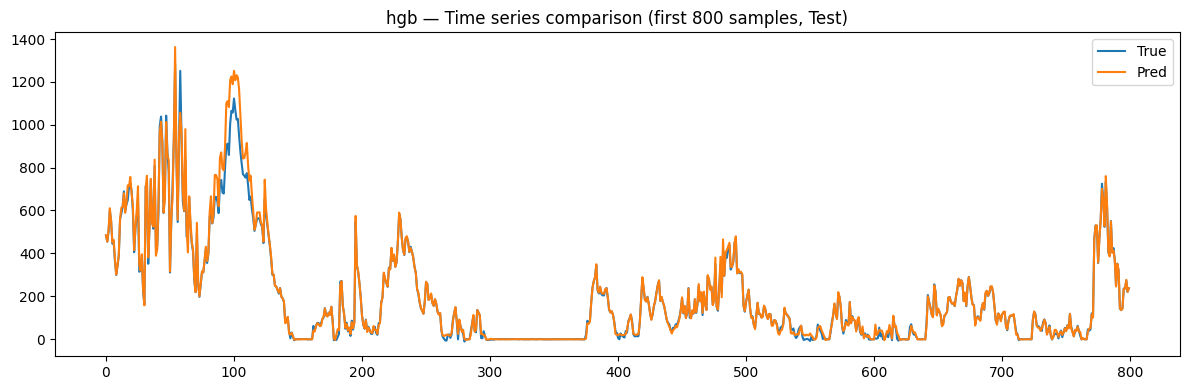

In [10]:
N = 800  # number of points to visualize
plt.figure(figsize=(12,4))
plt.plot(np.array(y_test)[:N], label="True")
plt.plot(np.array(y_pred)[:N], label="Pred")
plt.legend()
plt.title(f"{best_model_name} — Time series comparison (first {N} samples, Test)")
plt.tight_layout()
plt.show()

### 7 — Error distribution (test set)

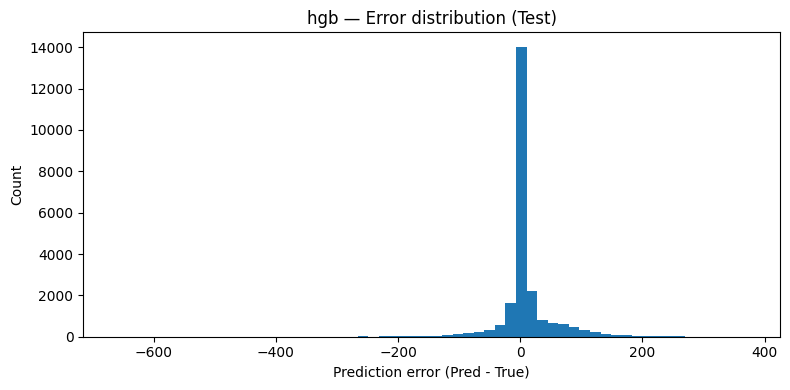

Error mean: 8.451419041573656
Error std: 45.99079253009572
Error 90% quantile abs: 73.65407120971096


In [11]:
errors = np.array(y_pred) - np.array(y_test)

plt.figure(figsize=(8,4))
plt.hist(errors, bins=60)
plt.xlabel("Prediction error (Pred - True)")
plt.ylabel("Count")
plt.title(f"{best_model_name} — Error distribution (Test)")
plt.tight_layout()
plt.show()

print("Error mean:", float(np.mean(errors)))
print("Error std:", float(np.std(errors)))
print("Error 90% quantile abs:", float(np.quantile(np.abs(errors), 0.90)))

### 8 — Sauvegarde des figures

In [12]:
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

## Conclusion sur WT3 :

**Model selection:** The best model is selected based on validation performance and confirmed on the test set.

### Observed ranking (expected on tabular data)
- Linear model (Ridge) underfits due to strong non-linear relationships.
- Tree ensembles (ExtraTrees) provide a strong baseline by capturing nonlinearities.
- Gradient Boosted Trees (HistGradientBoosting) achieves the best performance, which is consistent with state-of-the-art methods on structured/tabular datasets.
- MLP provides competitive performance but typically remains behind boosted trees on medium-sized tabular datasets.

### Final choice
The selected final model is **HistGradientBoostingRegressor** because it achieves:
- lowest MAE and RMSE
- highest R²
- strong generalization
- fast training and simple reproducibility


NB: MAPE is not emphasized because power values can be near zero during turbine stops, making percentage errors unstable.


## B — Additional experiment : Training on all turbines

### Objective
So far, models were trained on a single turbine (WT3) to learn turbine-specific behavior.

To compare with previous work and evaluate the impact of dataset size, we also train the best-performing model (HistGradientBoosting) on **all turbines combined (WT1–WT4)**.

Hypothesis:
- more training data → lower variance → better generalization → lower MAE


In [13]:
import json
from pathlib import Path

path_all = Path("../reports/results_hgb_none.json")

with open(path_all, "r") as f:
    res_all = json.load(f)

res_all

{'model': 'hgb',
 'turbine': 'none',
 'n_train': 432170,
 'n_val': 92608,
 'n_test': 92608,
 'mae_val': 12.9498386329987,
 'rmse_val': 38.9641732319267,
 'r2_val': 0.9892281730781974,
 'mape_val': 277.24215696120854,
 'mae_test': 13.412376766491885,
 'rmse_test': 30.452958581100134,
 'r2_test': 0.9964040396239744,
 'mape_test': 187.22764460455002,
 'model_path': 'C:\\Users\\intel\\Documents\\GitHub\\Projet-Deep-Learning---Engie\\models\\hgb_none.joblib',
 'parquet_path': 'C:\\Users\\intel\\Documents\\GitHub\\Projet-Deep-Learning---Engie\\data\\engie_full.parquet'}

## Results summary (All turbines)

In [14]:
# récupérer la ligne WT3 du tableau existant
wt3_row = df_res[df_res["model"] == "hgb"].iloc[0]

comparison = pd.DataFrame([
    {
        "setup": "WT3 only",
        "MAE_test": wt3_row["mae_test"],
        "RMSE_test": wt3_row["rmse_test"],
        "R2_test": wt3_row["r2_test"]
    },
    {
        "setup": "All turbines",
        "MAE_test": res_all["mae_test"],
        "RMSE_test": res_all["rmse_test"],
        "R2_test": res_all["r2_test"]
    }
])

comparison

,setup,MAE_test,RMSE_test,R2_test
0,WT3 only,22.556199,46.760876,0.992294
1,All turbines,13.412377,30.452959,0.996404


### 📊 Visual comparison

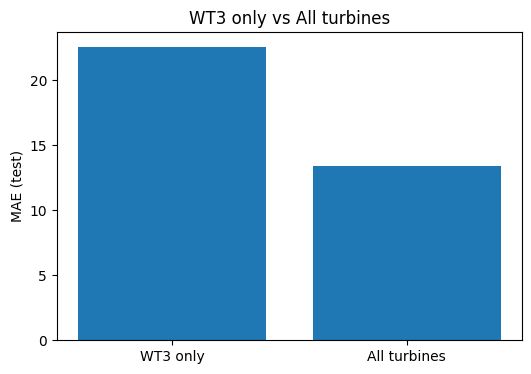

In [15]:
plt.figure(figsize=(6,4))
plt.bar(comparison["setup"], comparison["MAE_test"])
plt.ylabel("MAE (test)")
plt.title("WT3 only vs All turbines")
plt.show()

### Interpretation

Training on all turbines significantly improves performance:

- WT3 only: MAE ≈ 22.6
- All turbines: MAE ≈ 13.4

This confirms that increasing the dataset size reduces variance and improves generalization.

However, from an industrial perspective, turbine-specific models may still be preferred because:
- each turbine has different aging and calibration
- local weather conditions differ
- specialized models can better capture machine-specific behavior

Therefore:
- **Best accuracy** → All turbines model
- **Best operational realism** → Per-turbine models
